##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Parametrized Quantum Circuits for Reinforcement Learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_reinforcement_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial, you will implement two reinforcement learning (RL) algorithms based on parametrized/variational quantum circuits (PQCs or VQCs), namely a policy-gradient and a deep Q-learning implementation. These algorithms were introduced by [[1] Jerbi et al.](https://arxiv.org/abs/2103.05577) and [[2] Skolik et al.](https://arxiv.org/abs/2103.15084), respectively.

You will implement a PQC with data re-uploading in TFQ, and use it as:
1. an RL policy trained with a policy-gradient method,
2. a Q-function approximator trained with deep Q-learning,

each solving [CartPole-v1](http://gym.openai.com/envs/CartPole-v1/), a benchmarking task from OpenAI Gym. Note that, as showcased in [[1]](https://arxiv.org/abs/2103.05577) and [[2]](https://arxiv.org/abs/2103.15084), these agents can also be used to solve other task-environment from OpenAI Gym, such as [FrozenLake-v0](http://gym.openai.com/envs/FrozenLake-v0/), [MountainCar-v0](http://gym.openai.com/envs/MountainCar-v0/) or [Acrobot-v1](http://gym.openai.com/envs/Acrobot-v1/).

Features of this implementation:
- you will learn how to use a `tfq.layers.ControlledPQC` to implement a PQC with data re-uploading, appearing in many applications of QML. This implementation also naturally allows using trainable scaling parameters at the input of the PQC, to increase its expressivity,
- you will learn how to implement observables with trainable weights at the output of a PQC, to allow a flexible range of output values,
- you will learn how a `tf.keras.Model` can be trained with non-trivial ML loss functions, i.e., that are not compatible with `model.compile` and `model.fit`, using a `tf.GradientTape`.

## Setup

Install TensorFlow:

In [ ]:
!pip install -q tensorflow==2.3.1

Install TensorFlow Quantum:

In [ ]:
!pip install -q tensorflow-quantum

Install Gym:

In [ ]:
!pip install -q gym==0.18.0

Now import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy, random
import numpy as np
from functools import reduce
from collections import deque
from collections import namedtuple
import matplotlib.pyplot as plt

## 1. Build a PQC with data re-uploading

At the core of both RL algorithms you are implementing is a PQC that takes as input the agent's state $s$ in the environment (i.e., a numpy array) and outputs a vector of expectation values. These expectation values are then post-processed, either to produce an agent's policy $\pi(a|s)$ or approximate Q-values $Q(s,a)$. In this way, the PQCs are playing an analog role to that of deep neural networks in modern deep RL algorithms.

A popular way to encode an input vector in a PQC is through the use of single-qubit rotations, where rotation angles are controlled by the components of this input vector. In order to get a [highly-expressive model](https://arxiv.org/abs/2008.08605), these single-qubit encodings are not performed only once in the PQC, but in several "[re-uploadings](https://quantum-journal.org/papers/q-2020-02-06-226/)", interlayed with variational gates. The layout of such a PQC is depicted below:

<img src="./images/pqc_re-uploading.png" width="700">

As discussed in [[1]](https://arxiv.org/abs/2103.05577) and [[2]](https://arxiv.org/abs/2103.15084), a way to further enhance the expressivity and trainability of data re-uploading PQCs is to use trainable input-scaling parameters $\boldsymbol{\lambda}$ for each encoding gate of the PQC, and trainable observable weights $\boldsymbol{w}$ at its output.

### 1.1 Cirq circuit for ControlledPQC

The first step is to implement in Cirq the quantum circuit to be used by the PQC. For this, start by defining basic unitaries to be applied in the circuits, namely an arbitrary single-qubit rotation and an entangling layer of CZ gates:

In [2]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns a Cirq circuit that applies a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.rx(symbols[0])(qubit),
        cirq.ry(symbols[1])(qubit),
        cirq.rz(symbols[2])(qubit))

def entangling_layer(qubits):
    """
    Returns a Cirq circuit that applies a layer of entangling gates (arranged in a circular topology).
    """
    if len(qubits) == 2:
        return cirq.Circuit(cirq.CZ(qubits[0], qubits[1]))
    else:
        return cirq.Circuit(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]) for i in range(len(qubits)))

Now, use these functions to generate the Cirq circuit:

In [3]:
def generate_circuit(n, L, qubits):
    """
    Takes as input a number of qubits n, a number of layers L, and the qubits of the circuit.
    Returns a cirq circuit, the number of variational parameters, and the sympy symbols
    of variational and encoding angles.
    """
    # Number of variational angles
    theta_dim = 3*n*(L+1)
    
    # Sympy symbols for variational angles and encoding angles
    params = sympy.symbols('theta(0:'+str(theta_dim)+')')
    inputs = sympy.symbols(f'x(0:{n})'+f'(0:{L})') # every input component encoded in one gate
                                                                # per layer
    
    # Define circuit
    circuit = cirq.Circuit()
    for l in range(L):
        # Variational layer
        for i in range(n):
            circuit += one_qubit_rotation(qubits[i], params[3*(l*n+i):3*(l*n+i+1)])
        circuit += entangling_layer(qubits)
        # Encoding layer
        for i in range(n):
            circuit += cirq.rx(inputs[l+i*L])(qubits[i])
    # Last variational layer
    for i in range(n):
        circuit += one_qubit_rotation(qubits[i], params[3*(L*n+i):3*(L*n+i+1)])
    
    return circuit, theta_dim, params, inputs

Check that this produces a circuit that is alternating between variational and encoding layers.

In [4]:
n, L = 3, 1 # Number of qubits, number of layers
# Define qubits
qubits = [cirq.GridQubit(i,0) for i in range(n)]
# Generate circuit
circuit, _, _, _ = generate_circuit(n, L, qubits)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


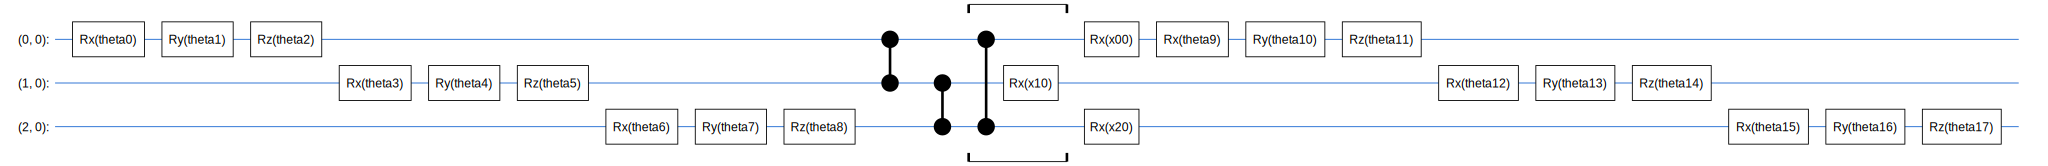

In [5]:
from cirq.contrib.svg import SVGCircuit

SVGCircuit(circuit)

### 1.2 Encoding layer for ControlledPQC

To construct the re-uploading PQC from the figure above, you can create a custom Keras layer. This layer will manage the trainable parameters (variational angles $\boldsymbol{\theta}$ and input-scaling parameters $\boldsymbol{\lambda}$) and resolve the input values (input state $s$) into the appropriate symbols in the circuit.

In [6]:
class Encoding(tf.keras.layers.Layer):
    """
    Stores all the variational parameters of the PQC, except for the observable weights,
        i.e., angles theta for variational gates and scaling parameters lmbd for encoding gates.
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=encoding_dim.
    An activation function from tf.keras.activations and specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i. For instance, the 'tanh' activation is useful for the Q-learning
        model to bound all angles to [-1,1].
    These are finally permuted such as to follow the alphabetical order of their names (provided in `angles`),
        as processed by the ControlledPQC.
    """
    def __init__(self, input_dim, theta_dim, encoding_dim, angles, activation='linear', name="encoding"):
        super(Encoding, self).__init__(name=name)
        self.input_dim = input_dim # dimension of input vector
        self.theta_dim = theta_dim # dimension of variational params vector
        self.encoding_dim = encoding_dim # number of repetitions of encoding of single input component
        theta_init = tf.random_uniform_initializer(minval=0., maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, theta_dim), dtype="float32"),
            trainable=True, name="thetas"
        )
        lmbd_init = tf.ones(shape=(1,input_dim*encoding_dim))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32",
            trainable=True, name="lambdas"
        )
        alphabetical_angles = sorted(angles)
        self.indices = tf.constant([alphabetical_angles.index(a) for a in angles]) # re-ordering of indices to
                                                                # match order of expectation_layer.symbols
        self.activation = activation # activation to be applied on the encoding angles

    def call(self, inputs):
        output = tf.repeat(self.theta,repeats=tf.shape(inputs)[0],axis=0)
        repeat_inputs = tf.repeat(inputs,repeats=self.encoding_dim,axis=1)
        repeat_lmbd = tf.repeat(self.lmbd,repeats=tf.shape(inputs)[0],axis=0)
        output = tf.concat([output, tf.keras.layers.Activation(self.activation)
                            (tf.math.multiply(repeat_inputs, repeat_lmbd))], 1)
        output = tf.gather(output, self.indices, axis=1) # re-ordering of indices to match order
                                                        # of expectation_layer.symbols
        return output

## 2. Policy-gradient RL with PQC policies

In this section, you will implement the policy-gradient algorithm presented in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a>. For this, you will start by constructing, out of the PQC we just defined, the `softmax-VQC` policy (where VQC stands for variational quantum circuit):
$$ \pi_\theta(a|s) = \frac{e^{\beta \langle O_a \rangle_{s,\theta}}}{\sum_{a'} e^{\beta \langle O_{a'} \rangle_{s,\theta}}} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the output of the PQC, and $\beta$ is a tunable inverse-temperature parameter. 

You can adopt the same observables used in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a> for CartPole, namely a global $Z_0Z_1Z_2Z_3$ Pauli product acting on all qubits, weighted by an action-specific weight for each action. To implement the weighting of the Pauli product, you can use an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation value $\langle Z_0Z_1Z_2Z_3 \rangle_{s,\theta}$.

In [7]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(-1.)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

Using the `generate_circuit` function previously defined, generate the PQC:

In [8]:
n = 4 # Dimension of the state vectors in CartPole
L = 5 # Number of layers in the PQC
nb_actions = 2 # Number of actions in CartPole

qubits = [cirq.GridQubit(i,0) for i in range(n)]

circuit, theta_dim, params, inputs = generate_circuit(n, L, qubits)

and its observables:

In [9]:
ops = [cirq.Z(qubits[i]) for i in range(n)]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

With this, define a `tf.keras.Model` that applies, sequentially, the `Encoding` layer previously defined, followed by a `ControlledPQC` layer using our Cirq circuit, a post-processing layer that computes the weighted observables using `Alternating`, which are then fed into a `tf.keras.layers.Softmax` layer that outputs the `softmax-VQC` policy of the agent.

In [10]:
def generate_model_policy(n, L, nb_actions, beta, circuit, theta_dim, params, inputs, observables):
    """
    Takes as input a number of qubits n, a number of layers L, a number of actions, an inverse temperature
    beta, a Cirq circuit, a number of variational angles, sympy symbols of variational and encoding angles,
    and the observables to be used at the output of the PQC.
    Returns the generated model of the PQC policy.
    """
    # Define input tensor
    input_tensor = tf.keras.Input(shape=(n), dtype=tf.dtypes.float32, name='input')

    # Define input quantum state
    input_q_state = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_state')
    
    #Define encoding layer
    encoding_layer = Encoding(input_dim=n, theta_dim=theta_dim, encoding_dim=L, 
                          angles=[str(param) for param in params]+[str(x) for x in inputs])
    
    # Define Controlled PQC
    expectation_layer = tfq.layers.ControlledPQC(circuit, differentiator = tfq.differentiators.Adjoint(),
                                                 operators = observables, name="PQC")
    
    # Define post-processing
    expectation_values = expectation_layer([input_q_state, encoding_layer(input_tensor)])
    process = tf.keras.Sequential([
        Alternating(nb_actions),
        tf.keras.layers.Lambda(lambda x: x * beta),
        tf.keras.layers.Softmax()
    ], name="observables-policy")
    
    policy = process(expectation_values)
    
    # Define model
    model = tf.keras.Model(inputs=[input_q_state, input_tensor],
                           outputs=policy, name="policy")
    
    return model

model = generate_model_policy(n, L, nb_actions, 1., circuit, theta_dim, params, inputs, observables)

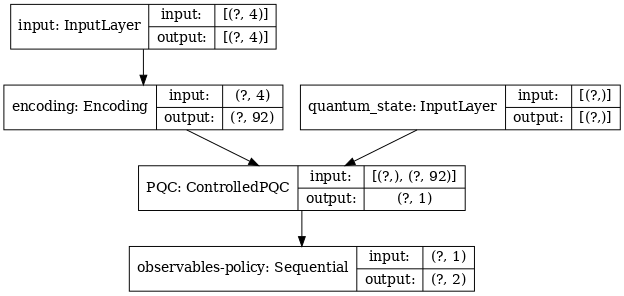

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

You can now train the PQC policy on CartPole-v1, using, e.g., the basic `REINFORCE` algorithm (see Alg. 1 in <a href="https://arxiv.org/abs/2103.05577" class="external">[1]</a>). We point out that:
1. Because scaling parameters, variational angles and observables weights are trained with different learning rates, it is convenient to define 3 separate optimizers with their own learning rates, each updating one of these groups of parameters.
2. The loss function in policy-gradient RL is
    $$ \mathcal{L}(\theta) = -\frac{1}{|\mathcal{B}|}\sum_{s_0,a_0,r_1,s_1,a_1, \ldots \in \mathcal{B}} \left(\sum_{t=0}^{H-1} \log(\pi_\theta(a_t|s_t)) \sum_{t'=1}^{H-t} \gamma^{t'} r_{t+t'} \right)$$
for a batch $\mathcal{B}$ of episodes $(s_0,a_0,r_1,s_1,a_1, \ldots)$ of interactions in the environment following the policy $\pi_\theta$. This is different from a supervised learning loss with fixed target values that the model should fit, which make it impossible to use a simple function call like `model.fit` to train the policy. Instead, using a `tf.GradientTape` allows to keep track of the computations involving the PQC (i.e., policy sampling) and store their contributions to the loss during the interaction. After running a batch of episodes, you can then apply backpropagation on these computations to get the gradients of the loss with respect to the PQC parameters and use the optimizers to update the policy-model.

Start by defining a function that performs an interaction step in the environment:

In [12]:
def interaction_env(state, state_bounds, model, nb_actions, env):
    # Preprocess state
    state = tf.convert_to_tensor(state/state_bounds)
    state = tf.expand_dims(state, 0)

    # Compute policy from env state
    action_probs = model([empty_circuits(1),state])

    # Sample action from policy
    action = np.random.choice(nb_actions, p=action_probs[0].numpy())
    p_action = action_probs[0, action]

    # Apply sampled action in the environment, receive reward and next state
    state, reward, done, _ = env.step(action)
    
    return p_action, state, reward, done

def empty_circuits(n):
    return tfq.convert_to_tensor([cirq.Circuit()]*n)

and a function that computes discounted returns $\sum_{t'=1}^{H-t} \gamma^{t'} r_{t+t'}$ out of the rewards $r_t$ collected in an episode:

In [13]:
def compute_returns(rewards_history, gamma):
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    # Normalize them for faster and more stable learning
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()
    
    return returns

Define the hyperparameters:

In [14]:
state_bounds = np.array([2.4, 2.5, 0.21, 2.5])
gamma = 1
batch_size = 10
nb_epsiodes = 500
nb_batches = int(nb_epsiodes/batch_size)

Prepare the optimizers:

In [15]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2
if (('lambdas' not in model.trainable_variables[w_in].name)
    or ('thetas' not in model.trainable_variables[w_var].name)
    or ('obs-weights' not in model.trainable_variables[w_out].name)):
    raise ValueError("Wrong indexing of optimizers parameters.")

Now implement the main training loop of the agent:

In [16]:
env = gym.make("CartPole-v1")

# Start training the agent
episode_reward_history = []
for batch in range(nb_batches):    
    loss_value = 0
    with tf.GradientTape() as tape:
        for episode in range(batch_size):
            log_policy_history, rewards_history = [], []
            state = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                # Interact with env
                p_action, state, reward, done = interaction_env(state, state_bounds, model, nb_actions, env)
                
                # Store contribution to loss
                log_policy_history.append(tf.math.log(p_action))
                
                # Store reward
                rewards_history.append(reward)
                episode_reward += reward
            
            # Compute returns 
            returns = compute_returns(rewards_history, gamma)
            
            # Add contributions to batch loss
            history = zip(log_policy_history, returns)
            losses = []
            for log_prob, ret in history:
                losses.append(-log_prob * ret)
            loss_value += sum(losses)
            
            episode_reward_history.append(episode_reward)
            if (batch*batch_size+episode+1)%10 == 0:
                print("Episode {}/{}, average last 10 rewards {}".format(batch*batch_size+episode+1,
                                            batch_size*nb_batches, np.mean(episode_reward_history[-10:])))
        
        # Compute gradient and train policy
        grads = tape.gradient(loss_value/batch_size, model.trainable_variables)
        for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
            optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])

Episode 10/500, average last 10 rewards 26.6
Episode 20/500, average last 10 rewards 23.7
Episode 30/500, average last 10 rewards 19.5
Episode 40/500, average last 10 rewards 20.7
Episode 50/500, average last 10 rewards 24.4
Episode 60/500, average last 10 rewards 18.1
Episode 70/500, average last 10 rewards 20.8
Episode 80/500, average last 10 rewards 23.5
Episode 90/500, average last 10 rewards 39.2
Episode 100/500, average last 10 rewards 20.4
Episode 110/500, average last 10 rewards 27.1
Episode 120/500, average last 10 rewards 36.7
Episode 130/500, average last 10 rewards 34.2
Episode 140/500, average last 10 rewards 51.1
Episode 150/500, average last 10 rewards 50.5
Episode 160/500, average last 10 rewards 79.4
Episode 170/500, average last 10 rewards 79.7
Episode 180/500, average last 10 rewards 125.9
Episode 190/500, average last 10 rewards 133.4
Episode 200/500, average last 10 rewards 192.6
Episode 210/500, average last 10 rewards 246.4
Episode 220/500, average last 10 reward

Plot the learning history of the agent:

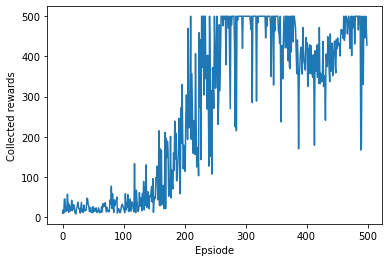

In [17]:
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

## 3. Deep Q-learning with PQC Q-function approximators

In this section, we move to the implementation of the deep Q-learning algorithm presented in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a>. As opposed to a policy-gradient approach, the deep Q-learning method uses a PQC to approximate the Q-function of the agent. That is, the PQC defines a function approximator:
$$ Q_\theta(s,a) = \langle O_a \rangle_{s,\theta} $$
where $\langle O_a \rangle_{s,\theta}$ are expectation values of observables $O_a$ (one per action) measured at the ouput of the PQC.

These Q-values are updated using a loss function derived from Q-learning:
$$ \mathcal{L}(\theta) = \frac{1}{|\mathcal{B}|}\sum_{s,a,r,s' \in \mathcal{B}} \left(Q_\theta(s,a) - [r +\max_{a'} Q_{\theta'}(s',a')]\right)^2$$
for a batch $\mathcal{B}$ of $1$-step interactions $(s,a,r,s')$ with the environment, sampled from the replay memory, and parameters $\theta'$ specifying the target PQC (i.e., a copy of the main PQC, whose parameters are sporadically copied from the main PQC throughout learning).

You can adopt the same observables used in <a href="https://arxiv.org/abs/2103.15084" class="external">[2]</a> for CartPole, namely a $Z_0Z_1$ Pauli product for action $0$ and a $Z_2Z_3$ Pauli product for action $1$. Both observables are re-scaled so their expectation values are in $[0,1]$ and weighted by an action-specific weight. To implement the re-scaling and weighting of the Pauli products, you can define again an extra `tf.keras.layers.Layer` that stores the action-specific weights and applies them multiplicatively on the expectation values $\left(1+\langle Z_0Z_1 \rangle_{s,\theta}\right)/2$ and $\left(1+\langle Z_2Z_3 \rangle_{s,\theta}\right)/2$.

In [7]:
class Rescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(Rescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w,repeats=tf.shape(inputs)[0],axis=0))

Using the `generate_circuit` function, generate the PQC and its observables:

In [8]:
n = 4 # Dimension of the state vectors in CartPole
L = 5 # Number of layers in the PQC
nb_actions = 2 # Number of actions in CartPole
qubits = [cirq.GridQubit(i,0) for i in range(n)]
circuit, theta_dim, params, inputs = generate_circuit(n, L, qubits)
ops = [cirq.Z(qubits[i]) for i in range(n)]
observables = [ops[0]*ops[1], ops[2]*ops[3]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

Define a `tf.keras.Model` that, similarly to the PQC-policy model, constructs a Q-function approximator that is used to generate the main and target models of our Q-learning agent.

In [9]:
def generate_model_Qlearning(n, L, circuit, theta_dim, params, inputs, observables, target):
    """
    Takes as input a number of qubits n, a number of layers L, a Cirq circuit, a number of variational angles,
    sympy symbols of variational and encoding angles, the observables to be used at the output of the PQC,
    and a boolean specifying if the generated model is a target model or main model.
    Returns the generated model of the PQC Q-function approximator.
    """
    # Define input tensor
    input_tensor = tf.keras.Input(shape=(n), dtype=tf.dtypes.float32, name='input')

    # Define input quantum state
    input_q_state = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_state')
    
    #Define encoding layer
    encoding_layer = Encoding(input_dim=n, theta_dim=theta_dim, encoding_dim=L, 
                         angles=[str(param) for param in params]+[str(x) for x in inputs], activation='tanh')
    
    # Define Controlled PQC
    expectation_layer = tfq.layers.ControlledPQC(circuit, differentiator = tfq.differentiators.Adjoint(),
                                                 operators = observables, name="PQC")
    
    prepend = ""
    if target:
        prepend = "Target"
    
    # Define post-processing
    expectation_values = expectation_layer([input_q_state, encoding_layer(input_tensor)])
    process = tf.keras.Sequential([
        Rescaling(len(observables))
    ], name=prepend+"Q-values")
    
    Q_values = process(expectation_values)
    
    # Define model
    model = tf.keras.Model(inputs=[input_q_state, input_tensor],
                           outputs=Q_values, name=prepend+"Q-function")
    
    return model

model = generate_model_Qlearning(n, L, circuit, theta_dim, params, inputs, observables, False)
model_target = generate_model_Qlearning(n, L, circuit, theta_dim, params, inputs, observables, True)

model_target.set_weights(model.get_weights())

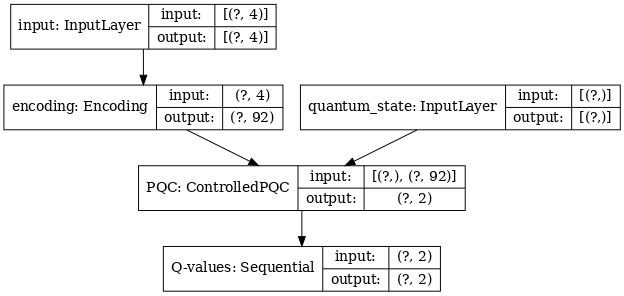

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

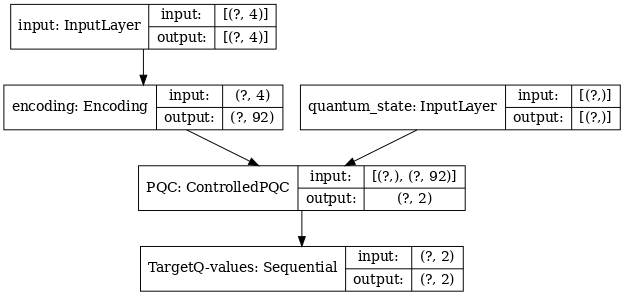

In [11]:
tf.keras.utils.plot_model(model_target, show_shapes=True, dpi=70)

You can now implement the deep Q-learning algorithm and test it on the CartPole-v1 environment. For the policy of the agent, you can use an $\varepsilon$-greedy policy:
$$ \pi(a|s) =
\begin{cases}
\delta_{a,\text{argmax}_{a'} Q_\theta(s,a')}\quad \text{w.p.}\quad 1 - \varepsilon\\
\frac{1}{\text{num_actions}}\quad \quad \quad \quad \text{w.p.}\quad \varepsilon
\end{cases} $$
where $\varepsilon$ is multiplicatively decayed at each episode of interaction.

Start by defining a function that performs an interaction step in the environment:

In [12]:
def interaction_env(state, model, epsilon, nb_actions, env):
    # Preprocess state
    state_array = np.array(state) 
    state = tf.convert_to_tensor(state_array)
    state = tf.expand_dims(state, 0)

    # Sample action
    coin = random.random()
    if coin > epsilon:
        q_vals = model([empty_circuits(1),state])
        action = int(tf.argmax(q_vals[0]).numpy())
    else:
        action = np.random.choice(nb_actions)

    # Apply sampled action in the environment, receive reward and next state
    next_state, reward, done, _ = env.step(action)
    
    return state_array, action, next_state, reward, done

def empty_circuits(n):
    return tfq.convert_to_tensor([cirq.Circuit()]*n)

and a function that computes the Q-learning loss:

In [13]:
def Q_learning_loss(replay_memory, batch_size, loss_function, model, model_target, gamma, nb_actions):
    # Sample a batch of interactions
    batch = random.choices(replay_memory, k=batch_size)
    batch = interaction(*zip(*batch))

    # Compute their target q_values and the masks on sampled actions
    future_rewards = model_target.predict([empty_circuits(batch_size),tf.constant(batch.next_state)])
    target_q_values = tf.constant(batch.reward) + (gamma * tf.reduce_max(future_rewards, axis=1)
                                                   * (1 - tf.constant(batch.done)))
    masks = tf.one_hot(batch.action, nb_actions)

    # Train the model on the states and target Q-values
    with tf.GradientTape() as tape:
        q_values = model([empty_circuits(batch_size),tf.constant(batch.state)])
        # Apply the masks to the Q-values
        q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
        # Calculate loss between target Q-values and model Q-values
        loss = loss_function(target_q_values, q_values_masked)
    return tape, loss

Define the hyperparameters:

In [14]:
gamma = 0.99
nb_episodes = 2000

# Define replay memory
max_memory_length = 10000 # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99 # Decay rate of epsilon greedy parameter
batch_size = 16
update_VQC = 10 # Train the model every update_VQC steps
update_target = 30 # Update the target model every update_target steps

Prepare the optimizers:

In [15]:
optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2
if (('lambdas' not in model.trainable_variables[w_in].name)
    or ('thetas' not in model.trainable_variables[w_var].name)
    or ('obs-weights' not in model.trainable_variables[w_out].name)):
    raise ValueError("Wrong indexing of optimizers parameters.")

Now implement the main training loop of the agent.

N.B. Training the Q-learning agent until convergence to the optimal policy can take several hours to run. If you only want to test your code, you can train it on a few hundred episodes only. Otherwise, comment/skip the following cell.

In [16]:
nb_episodes = 500

In [18]:
env = gym.make("CartPole-v1")

interaction = namedtuple('interaction', ('state', 'action', 'reward', 'next_state', 'done'))

# Prepare loss function
loss_function = tf.keras.losses.Huber()
    
episode_reward_history = []
step_count = 0
for episode in range(nb_episodes):
    episode_reward = 0
    state = env.reset()
    done = False
    
    while not done:
        # Increase step count
        step_count += 1
        
        # Interact with env
        state, action, next_state, reward, done = interaction_env(state, model, epsilon, nb_actions, env)
        
        # Store last interaction in the replay memory
        sarsd = interaction(np.copy(state), action, reward, np.copy(next_state), float(done))
        replay_memory.append(sarsd)
        
        state = np.array(next_state)
        episode_reward += reward
        
        # Update model
        if step_count % update_VQC == 0 and len(replay_memory) >= batch_size:
            # Compute loss
            tape, loss = Q_learning_loss(replay_memory, batch_size, loss_function, model, model_target, 
                                         gamma, nb_actions)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out], [w_in, w_var, w_out]):
                optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
        
        # Update target model
        if episode % update_target == 0:
            model_target.set_weights(model.get_weights())

    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    if (episode+1)%10 == 0:
        print("Episode {}/{}, average last 10 rewards {}".format(episode+1, nb_episodes,
                                                          np.mean(episode_reward_history[-10:])))

Episode 10/2000, average last 10 rewards 20.9
Episode 20/2000, average last 10 rewards 24.9
Episode 30/2000, average last 10 rewards 20.3
Episode 40/2000, average last 10 rewards 15.5
Episode 50/2000, average last 10 rewards 17.0
Episode 60/2000, average last 10 rewards 45.5
Episode 70/2000, average last 10 rewards 57.5
Episode 80/2000, average last 10 rewards 34.6
Episode 90/2000, average last 10 rewards 50.1
Episode 100/2000, average last 10 rewards 51.5
Episode 110/2000, average last 10 rewards 41.8
Episode 120/2000, average last 10 rewards 71.2
Episode 130/2000, average last 10 rewards 66.5
Episode 140/2000, average last 10 rewards 44.5
Episode 150/2000, average last 10 rewards 99.6
Episode 160/2000, average last 10 rewards 97.8
Episode 170/2000, average last 10 rewards 66.8
Episode 180/2000, average last 10 rewards 72.7
Episode 190/2000, average last 10 rewards 90.7
Episode 200/2000, average last 10 rewards 124.5
Episode 210/2000, average last 10 rewards 111.4
Episode 220/2000, av

Episode 1720/2000, average last 10 rewards 347.0
Episode 1730/2000, average last 10 rewards 500.0
Episode 1740/2000, average last 10 rewards 488.1
Episode 1750/2000, average last 10 rewards 460.7
Episode 1760/2000, average last 10 rewards 492.1
Episode 1770/2000, average last 10 rewards 492.3
Episode 1780/2000, average last 10 rewards 500.0
Episode 1790/2000, average last 10 rewards 500.0
Episode 1800/2000, average last 10 rewards 461.0
Episode 1810/2000, average last 10 rewards 500.0
Episode 1820/2000, average last 10 rewards 500.0
Episode 1830/2000, average last 10 rewards 500.0
Episode 1840/2000, average last 10 rewards 490.2
Episode 1850/2000, average last 10 rewards 500.0
Episode 1860/2000, average last 10 rewards 500.0
Episode 1870/2000, average last 10 rewards 500.0
Episode 1880/2000, average last 10 rewards 500.0
Episode 1890/2000, average last 10 rewards 500.0
Episode 1900/2000, average last 10 rewards 500.0
Episode 1910/2000, average last 10 rewards 500.0
Episode 1920/2000, a

Plot the learning history of the agent:

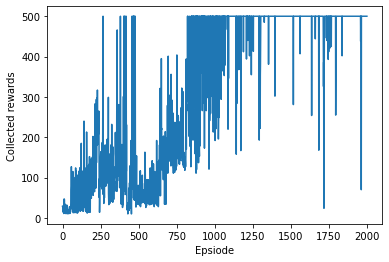

In [19]:
plt.plot(episode_reward_history)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()

## 4. Exercise

Combine the PQC models of the last two sections into an [actor-critic agent](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic) that solves CartPole.